Pydantic is a Python library for data validation and settings management using Python-type annotations. It ensures that the data you work with matches your specified data types, simplifying error handling and data parsing in Python applications. 

In [19]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz:str
    abc:str

In [21]:
import os
from dotenv import load_dotenv
load_dotenv()

#from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
#os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'finish_reason': 'stop', 'logprobs': None}, id='run-b219524f-a16a-4468-b9cf-c3e5b8f56ddd-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18})

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

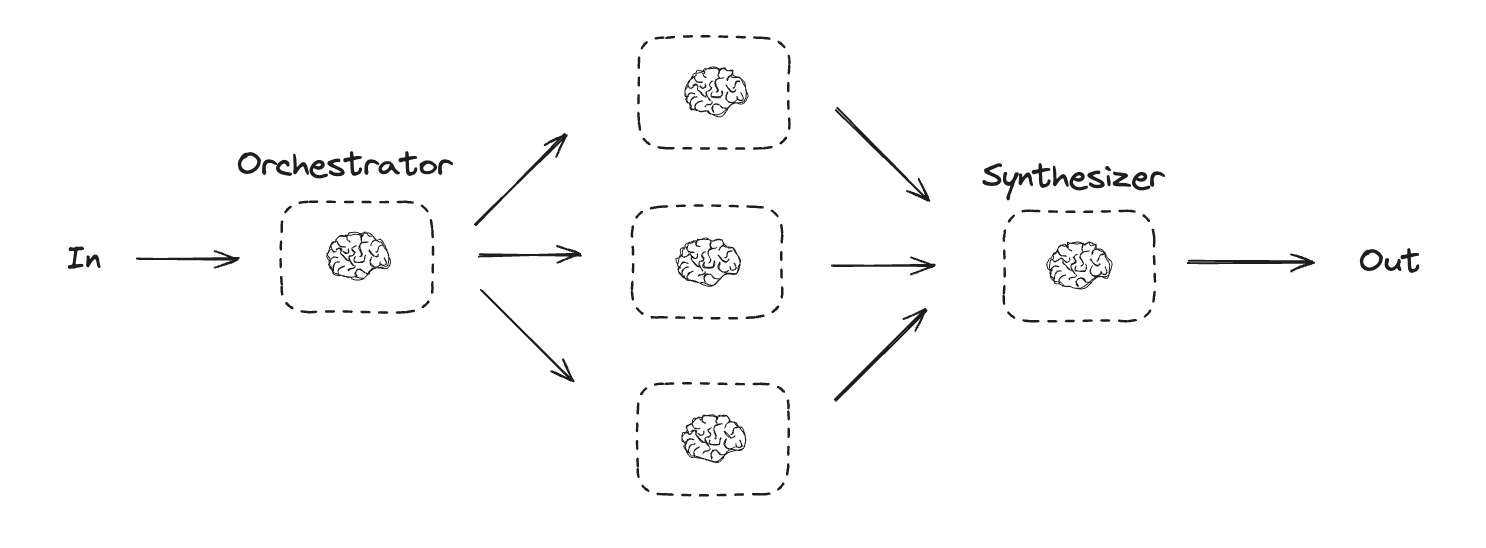

In [22]:

from typing import Annotated, List
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [23]:
from langgraph.constants import Send
from langchain_core.messages import HumanMessage, SystemMessage

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


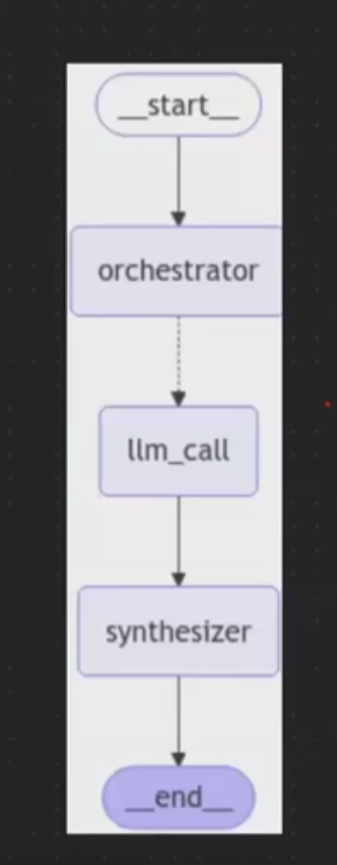

In [24]:
from langchain_core.messages import HumanMessage, SystemMessage
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
#display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction to LLM Scaling Laws', description='This section will provide an overview of what LLM scaling laws are, including their significance in the field of artificial intelligence and machine learning. It will introduce key concepts and the motivation behind studying these scaling laws.'), Section(name='Historical Development', description='This section will explore the historical development of LLM scaling laws, tracing their evolution from early research to current understanding. It will highlight major milestones and key figures who have contributed to this area of study.'), Section(name='Mathematical Foundation', description='This section will delve into the mathematical theories and models that underpin LLM scaling laws. It will cover the equations and principles that describe how model performance scales with size, data, and computational resources.'), Section(name='Empirical Observations', description='This section will present empir

## Introduction to LLM Scaling Laws

Large Language Model (LLM) scaling laws are foundational principles that describe how the performance of language models improves as they are scaled in terms of parameters, data, and computational resources. These scaling laws are significant in artificial intelligence (AI) and machine learning (ML) as they provide insights into the growth trajectory of model capabilities and guide the optimal allocation of resources.

### Key Concepts

The concept of scaling laws in the context of LLMs revolves around the relationship between model size, training data quantity, and computational power. The primary parameters under consideration include:

- **Model Size:** Refers to the number of parameters in a language model. Larger models generally have greater capacity to learn complex patterns from data.
- **Training Data:** The amount and quality of data used during training. More extensive datasets enable models to generalize better across diverse tasks.
- **Compute Resources:** The computational power required for training and deploying models. This includes considerations of processing speed and memory capacity.

### Significance in AI and ML

The significance of LLM scaling laws lies in their ability to predict improvements in model performance as models are scaled. This has several implications:

1. **Resource Allocation:** By understanding scaling laws, researchers and organizations can make informed decisions about the investment in model size versus data quantity or compute power, optimizing for the best performance outcomes.
2. **Strategic Planning:** Scaling laws help in forecasting future advancements in AI by predicting how far current technologies can be extended with increasing resources.
3. **Benchmarking Progress:** They provide a framework to evaluate whether observed improvements in models are consistent with expected scaling trends, offering a benchmark for progress in AI development.

### Motivation for Studying Scaling Laws

The motivation behind studying LLM scaling laws is rooted in the quest to maximize the efficiency and effectiveness of language models. As AI applications become more prevalent, understanding the dynamics of scaling is crucial for:

- **Advancing Model Capabilities:** Identifying the most effective pathways to enhance model performance.
- **Cost Efficiency:** Balancing the trade-offs between computational cost and performance gains, crucial for commercial applications where resources are finite.
- **Scientific Insight:** Gaining deeper insights into the nature of language understanding and generation, contributing to the broader field of cognitive and computational sciences.

By examining how language models behave as they scale, researchers can uncover the underlying principles of intelligence and design more robust, capable, and efficient AI systems.

---

## Historical Development

The study of scaling laws in large language models (LLMs) has seen significant evolution over the years, marking crucial advancements in understanding how model performance scales with size and data. This section delves into the historical trajectory of LLM scaling laws, highlighting pivotal research, key contributions, and the evolution of theoretical and practical insights.

### Early Research and Foundations

The concept of scaling laws in machine learning can be traced back to the early 2000s when researchers began to systematically study how model performance improved with increased amounts of data and computational resources. Initial studies focused on simpler machine learning models, establishing foundational ideas that would later be applied to neural networks and, eventually, LLMs.

### The Advent of Neural Networks

With the resurgence of neural networks in the 2010s, thanks to increased computational power and large datasets, researchers started to explore how these models could be scaled. The work of key figures such as Geoffrey Hinton and Yann LeCun laid the groundwork for understanding deep learning dynamics, although direct scaling laws for LLMs were not yet a focus.

### Emergence of Scaling Laws for LLMs

The turning point for scaling laws in LLMs came with the introduction of the Transformer architecture by Vaswani et al. in 2017. This architecture enabled significant improvements in processing sequential data and sparked interest in scaling these models. Building on this, OpenAI's GPT (Generative Pre-trained Transformer) series of models became a focal point for understanding scaling laws in the context of LLMs. 

In 2020, the seminal paper by Kaplan et al., "Scaling Laws for Neural Language Models," provided a comprehensive study on how LLM performance scales with model size, dataset size, and computational power. This research demonstrated that performance improvements followed predictable patterns, establishing a formal framework for scaling laws. The work by Kaplan and his team became a cornerstone in the field, influencing subsequent research and development.

### Major Milestones and Developments

Following the foundational work by Kaplan et al., several key milestones have shaped the understanding of LLM scaling laws:

- **GPT-3 (2020):** OpenAI's release of GPT-3 served as a practical demonstration of scaling laws, showcasing how a substantial increase in parameters led to unprecedented performance in natural language processing tasks.
  
- **DeepMind's Scaling Laws:** Research from DeepMind further refined understanding by exploring the implications of scaling laws for different architectures and tasks, adding depth to the theoretical framework.

- **Chinchilla and Gopher (2022):** Studies by DeepMind, including the development of models like Chinchilla and Gopher, highlighted the importance of data efficiency and the interplay between model size and data quantity, refining earlier scaling laws.

- **Emergent Abilities (2023):** Recent research has begun exploring emergent abilities in LLMs as they reach certain scale thresholds, contributing to a nuanced understanding of scaling laws beyond linear improvements.

### Key Contributors

Several researchers and organizations have been instrumental in advancing the field of LLM scaling laws. Notable figures include Ilya Sutskever and Dario Amodei from OpenAI, who have driven much of the practical application of scaling laws through the development of large-scale models. DeepMind's contributions have also been significant, with researchers like Oriol Vinyals and Koray Kavukcuoglu pushing the boundaries of theoretical understanding.

### Current Understanding and Future Directions

Today, scaling laws are a critical aspect of LLM research, guiding both the development and deployment of models. The focus has shifted towards optimizing resource usage while maximizing performance, with ongoing research exploring new architectures, efficiency techniques, and the theoretical underpinnings of scaling laws. The field continues to evolve, promising further breakthroughs in the capabilities of language models.

---

## Mathematical Foundation

The mathematical foundation of LLM (Large Language Model) scaling laws is rooted in statistical learning theory and information theory, providing a framework for understanding how model performance is influenced by changes in model size, data quantity, and computational resources. This section will explore the key equations, principles, and theoretical models that describe these scaling behaviors.

### Scaling Laws for Model Performance

The performance of LLMs is often characterized by power-law scaling, which describes the relationship between the performance metric (such as loss or accuracy) and the size of the model, the amount of data, or the computational resources utilized. The general form of the power-law scaling can be expressed as:

\[ P(N, D, C) = aN^{-\alpha} + bD^{-\beta} + cC^{-\gamma} + \epsilon \]

Where:
- \( P \) represents the performance metric.
- \( N \), \( D \), and \( C \) denote the model size (e.g., the number of parameters), the data size, and the computational resources, respectively.
- \( a \), \( b \), and \( c \) are constants that can vary based on the specific architecture and training process.
- \( \alpha \), \( \beta \), and \( \gamma \) are scaling exponents that define the rate of performance improvement with respect to each variable.
- \( \epsilon \) is a noise term accounting for random fluctuations and unmodeled variability.

### Model Size Scaling

The scaling of model performance with respect to model size \( N \) is a key aspect of LLM design. Theoretical models suggest that larger models can capture more complex patterns within the data, thereby improving performance. The relationship is often sublinear, with diminishing returns as model size increases. The scaling exponent \( \alpha \) typically lies between 0 and 1, indicating a decelerating improvement rate.

### Data Scaling

Data scaling laws describe how performance improves with the availability of more training data \( D \). The principle underpinning this relationship is that more data allows the model to generalize better by learning a wider variety of features and patterns. The scaling exponent \( \beta \) is crucial for understanding the efficiency of data usage, with a higher exponent signifying greater sensitivity to data size increases.

### Computational Resource Scaling

The impact of computational resources \( C \) on model performance is also governed by scaling laws. Efficient use of computational resources can lead to significant performance gains, particularly through techniques such as parallel processing and optimized hardware utilization. The scaling exponent \( \gamma \) provides insight into how effectively computational advancements translate into performance improvements.

### Theoretical Implications

The mathematical exploration of LLM scaling laws has profound implications for model design and resource allocation. By understanding these scaling relationships, researchers and practitioners can make informed decisions about the trade-offs between model size, data requirements, and computational investment. This mathematical framework not only guides the development of more efficient models but also helps in predicting future performance trends as technology evolves.

### Conclusion

The mathematical foundation of LLM scaling laws offers a rigorous basis for analyzing and predicting the performance of large language models. By elucidating the equations and principles that govern these relationships, this section provides a comprehensive understanding of how scaling influences model efficacy, shaping the future trajectory of artificial intelligence research and application.

---

## Empirical Observations

Empirical research into Large Language Model (LLM) scaling laws has yielded significant insights that both support and challenge existing theoretical frameworks. This section presents key findings from experimental results and real-world data, offering a comprehensive view of how LLMs behave as they scale.

### Experimentation and Results

1. **Model Performance and Size Correlation**: Numerous studies have consistently shown a strong correlation between the size of a language model and its performance across various linguistic tasks. For instance, models scaling from millions to billions of parameters demonstrate marked improvements in benchmarks like GLUE and SuperGLUE. These findings reinforce the hypothesis that larger models have a greater capacity to capture complex language patterns.

2. **Diminishing Returns**: While larger models generally perform better, empirical data suggests a point of diminishing returns in performance relative to the increase in computational resources. After a certain scale, improvements become incremental rather than exponential, challenging the notion that simply increasing size will continue to yield substantial gains.

3. **Efficiency and Optimization**: Real-world data highlights the importance of optimization strategies in scaling LLMs. Techniques such as sparsity, model distillation, and parameter sharing have been empirically proven to maintain performance while reducing computational overhead, suggesting that efficiency can be as crucial as raw scale in model development.

4. **Generalization vs. Memorization**: Empirical observations indicate that as models scale, they risk overfitting, particularly when trained on insufficiently diverse datasets. This tendency raises concerns about the balance between generalization and memorization, challenging theories that posit larger models inherently generalize better.

### Real-World Data Implications

1. **Adaptability and Transfer Learning**: Real-world applications demonstrate that larger models exhibit superior adaptability and transfer learning capabilities, effectively applying learned knowledge from one task to another. This supports theories suggesting that scaling enhances a model's ability to function across diverse contexts.

2. **Ethical and Societal Impact**: Observational data from real-world deployments highlight significant ethical considerations, such as bias and fairness, which can be exacerbated in larger models. These findings challenge theoretical assertions that scaling can inherently address bias without targeted interventions.

3. **Economic and Environmental Costs**: The deployment of large-scale LLMs in production environments has brought attention to the substantial economic and environmental costs associated with their training and operation. Empirical results call for a reevaluation of scaling strategies to prioritize sustainability alongside performance.

### Synthesis and Implications

Overall, empirical observations provide a nuanced understanding of LLM scaling laws. While larger models generally offer enhanced capabilities, their development and deployment present complex challenges that extend beyond theoretical predictions. These findings underscore the need for a balanced approach that integrates empirical evidence with theoretical insights to guide future advancements in LLM technology.

---

## Applications and Implications

### Practical Applications of LLM Scaling Laws

The understanding of scaling laws in large language models (LLMs) has profound implications for their development and deployment. By identifying the relationships between model size, dataset size, and computational resources, researchers can optimize the design and training of LLMs to achieve desired performance levels more efficiently. This optimization allows for the development of models that are both cost-effective and powerful, facilitating advancements in various applications such as natural language processing, machine translation, and conversational agents.

One practical application of scaling laws is in resource allocation during model training. Organizations can better predict and manage the computational and financial resources required to train large models, leading to more sustainable and environmentally friendly AI practices. Additionally, scaling laws enable the creation of smaller models with comparable performance to larger ones, which is particularly beneficial for deployment in resource-constrained environments like mobile devices or edge computing platforms.

### Broader Implications for AI Research and Industry

The elucidation of scaling laws has significant implications for both AI research and the broader industry. For researchers, these laws provide a framework for understanding the underlying principles that govern model performance, guiding future research directions and fostering innovation. This understanding can lead to the development of new architectures and training methodologies that push the boundaries of what is currently possible with AI.

In the industry, scaling laws offer insights into the economic aspects of model development. Companies can make more informed decisions regarding investments in AI infrastructure and talent, ensuring that their AI initiatives are both economically viable and competitive. Furthermore, the ability to predict model performance based on size and training data helps companies strategize the integration of AI into their products and services, enhancing their offerings and customer experiences.

### Potential Benefits

The application of scaling laws can lead to several benefits across various sectors. In healthcare, for instance, more efficient LLMs can facilitate the development of advanced diagnostic tools and personalized medicine, improving patient outcomes. In education, scalable models can provide personalized learning experiences, adapting to the needs and progress of individual students. Additionally, in finance, scalable AI models can enhance fraud detection and risk management, leading to more secure and reliable financial systems.

### Challenges

Despite these benefits, the application of LLM scaling laws also presents challenges. The computational demands of training large models raise concerns about energy consumption and environmental impact, necessitating the development of more sustainable AI practices. Moreover, as LLMs become more prevalent, issues surrounding data privacy and security become increasingly critical, requiring robust solutions to protect sensitive information.

Ethical considerations also come into play, particularly concerning bias and fairness in AI systems. As models scale, ensuring that they do not perpetuate or amplify existing biases in data is a significant challenge that researchers and practitioners must address. Furthermore, the centralization of AI capabilities in a few large organizations poses risks related to market monopolization and the concentration of power, which could stifle innovation and limit access to AI technologies.

In conclusion, while LLM scaling laws offer a roadmap for advancing AI capabilities, they also bring forth a set of challenges that require careful consideration and proactive management. By addressing these challenges, the AI community can harness the full potential of scalable models to drive innovation and societal benefit.

---

## Future Directions

The field of LLM scaling laws is rapidly evolving, with numerous avenues for future research. As the development and deployment of large language models (LLMs) continue to accelerate, understanding the implications of scaling laws becomes increasingly critical. This section outlines several key areas where further investigation is needed, highlighting emerging trends and unanswered questions that could shape the trajectory of future research.

### Emerging Trends

1. **Multimodal Integration**: As LLMs begin to incorporate multiple modalities beyond text, such as images and audio, research is needed to understand how scaling laws apply in these contexts. The interplay between different types of data and model architecture will likely influence performance and efficiency, warranting detailed study.

2. **Efficient Scaling**: The pursuit of more computationally efficient models remains a significant research priority. Investigating alternative scaling strategies that maintain or improve performance while reducing resource consumption could lead to more sustainable AI development practices.

3. **Transfer and Generalization**: As models scale, their ability to generalize and transfer learning across tasks and domains becomes paramount. Future research should explore how scaling laws impact these capabilities and identify the conditions under which LLMs exhibit robust generalization.

### Unanswered Questions

1. **Theoretical Underpinnings**: Despite empirical evidence supporting scaling laws, the theoretical basis for these laws remains underexplored. Further theoretical work is needed to understand why scaling laws hold and to identify any potential limitations or exceptions.

2. **Interpretable Scaling**: As models grow in complexity, so does the challenge of interpretability. Research into how scaling affects model interpretability and the development of tools to elucidate this relationship will be crucial for ensuring transparency and trust in AI systems.

3. **Bias and Fairness**: Larger models are not immune to biases present in their training data. Investigating how scaling influences model bias and developing methods to mitigate these issues is critical to ensuring fair and equitable AI systems.

### Areas for Further Investigation

1. **Robustness and Stability**: Scaling laws often emphasize performance metrics, but the robustness and stability of LLMs under various conditions are equally important. Future research should examine how scaling affects these aspects and identify strategies to enhance model resilience.

2. **Cross-Disciplinary Approaches**: Collaborations between fields such as cognitive science, linguistics, and computer science could yield valuable insights into scaling laws. By integrating diverse perspectives, researchers can better understand the broader implications of LLM scaling.

3. **Ethical and Societal Impacts**: As LLMs become more powerful, their potential societal impacts—both positive and negative—must be carefully considered. Research should focus on understanding these implications and developing guidelines to ensure responsible deployment.

In conclusion, the study of LLM scaling laws presents a rich tapestry of research opportunities. Addressing these emerging trends, unanswered questions, and areas for further investigation will not only advance the field but also ensure that the development of LLMs aligns with broader societal goals.

---

## Conclusion

In this report, we have explored the fundamental aspects and implications of Large Language Model (LLM) scaling laws, which are pivotal in understanding the trajectory of artificial intelligence and machine learning advancements. The analysis underscored several key points:

1. **Understanding LLM Scaling Laws**: Scaling laws provide a mathematical framework to predict the performance of language models as they increase in size. They offer insights into the relationship between model size, dataset size, and computational resources to achieve optimal performance.

2. **Impact on Model Performance**: The scaling of language models has shown to significantly improve their capabilities in tasks such as natural language understanding, generation, and translation. Larger models, when trained on vast datasets, demonstrate superior performance compared to their smaller counterparts, achieving state-of-the-art results across various benchmarks.

3. **Resource Considerations**: While scaling laws indicate performance benefits, they also highlight the challenges associated with computational and financial resources. The need for substantial computational infrastructure and the associated costs underscore the importance of balancing model size with available resources.

4. **Implications for Future AI Development**: The insights gained from scaling laws are essential for guiding future AI research and development. By understanding the trade-offs between model size and performance, researchers and developers can make informed decisions about model architecture and resource allocation, fostering more efficient and powerful AI systems.

5. **Ethical and Societal Considerations**: As LLMs continue to scale, it is crucial to address the ethical implications and societal impact. Issues such as data privacy, algorithmic bias, and environmental sustainability become increasingly significant as models grow larger and more capable.

In conclusion, LLM scaling laws are not merely a technical curiosity but a cornerstone of modern AI research. Their insights guide the strategic development of AI technologies, promising enhanced capabilities while prompting careful consideration of their broader impacts. As the field of AI continues to evolve, scaling laws will remain a critical tool in shaping the future landscape of intelligent systems.

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

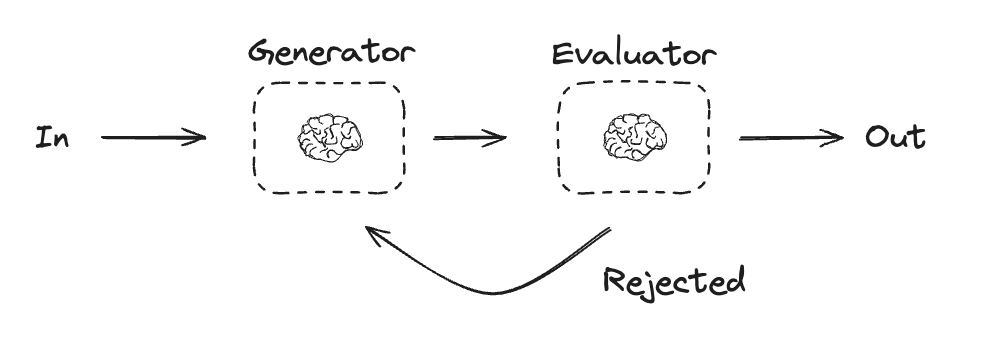

In [13]:
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [16]:
from typing import Literal
from IPython.display import Image
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

ValueError: Failed to render the graph using the Mermaid.INK API. Status code: 524.